For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

In [1]:
import pandas as pd 
import os
import requests
import seaborn as sns
import numpy as py
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import acquire as a
import prepare as p

In [2]:
plt.rc('figure', figsize=(13,7))
plt.rc('font', size=14)
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('df_complete.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       913000 non-null  int64  
 1   item_brand       913000 non-null  object 
 2   item_id          913000 non-null  int64  
 3   item_name        913000 non-null  object 
 4   item_price       913000 non-null  float64
 5   item_upc12       913000 non-null  int64  
 6   item_upc14       913000 non-null  int64  
 7   sale_amount      913000 non-null  float64
 8   sale_date        913000 non-null  object 
 9   sale_id          913000 non-null  int64  
 10  store            913000 non-null  int64  
 11  store_address_x  913000 non-null  object 
 12  store_city_x     913000 non-null  object 
 13  store_state_x    913000 non-null  object 
 14  store_zipcode_x  913000 non-null  int64  
 15  store_address_y  913000 non-null  object 
 16  store_city_y     913000 non-null  obje

In [5]:
df.sale_date = df.sale_date.apply(lambda date: date[:-13])

In [6]:
df.sale_date = pd.to_datetime(df.sale_date, format='%a, %d %b %Y')

In [7]:
df = df.set_index('sale_date')

In [8]:
#Split the data for exploration
train = df.loc[:'2016'] #everything up to the test_start_index
test = df.loc['2017'] #everything from the test start index to the end

<AxesSubplot:xlabel='sale_date'>

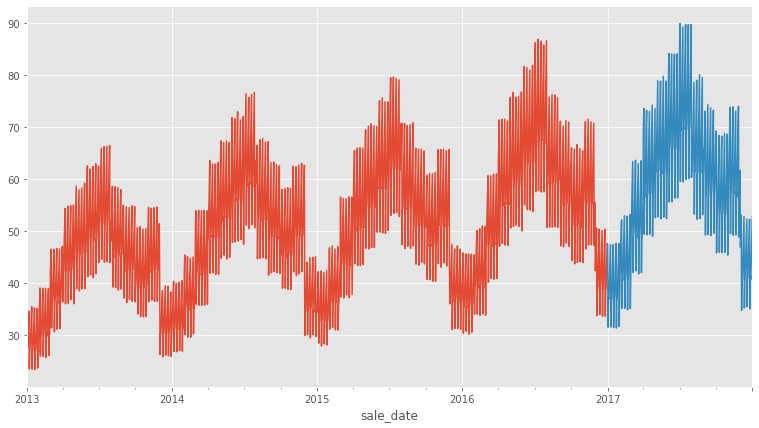

In [9]:
train.resample('D').sale_amount.mean().plot()
test.resample('D').sale_amount.mean().plot()

In [10]:
y = train.resample('D').sale_amount.mean()

Text(0, 0.5, 'Difference in sales from one day to the next')

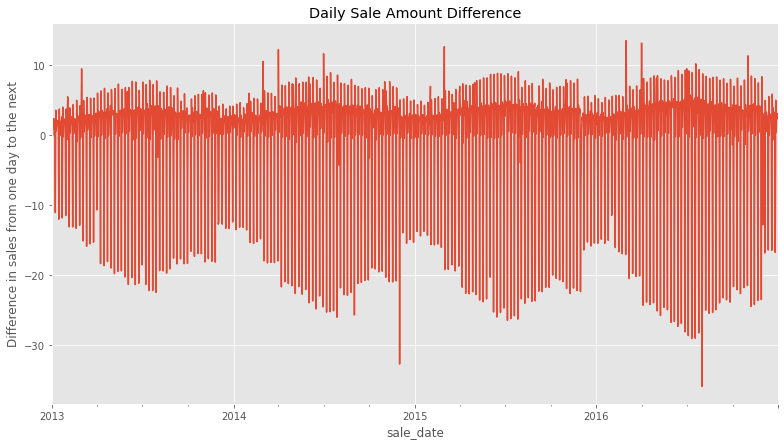

In [11]:
y.diff().plot()
plt.title("Daily Sale Amount Difference")
plt.ylabel("Difference in sales from one day to the next")

Text(0, 0.5, '% label')

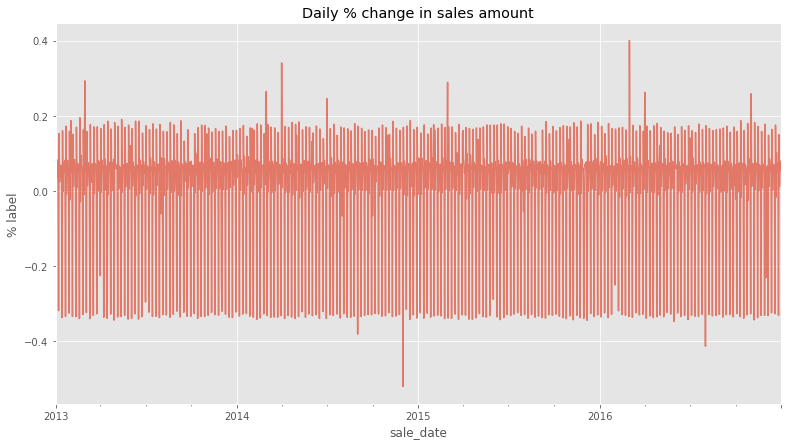

In [12]:
(y.diff()/y.shift()).plot(alpha=.7)
plt.title("Daily % change in sales amount")
plt.ylabel("% label")

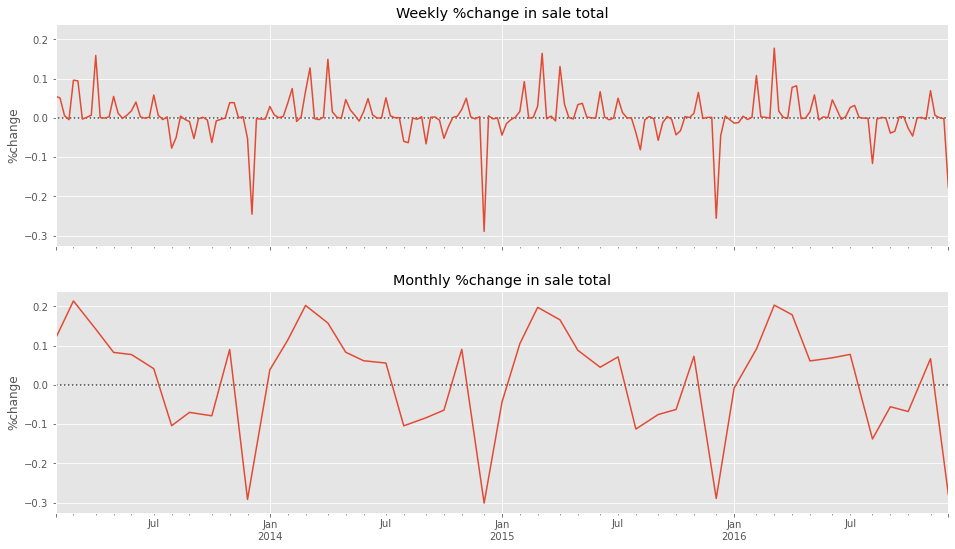

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 9))

weekly = y.resample("W").mean()
(weekly.diff()/weekly.shift()).plot(ax=ax1)
ax1.hlines(0, *ax1.get_xlim(), color='black',alpha =.7, ls=':')
ax1.set(title='Weekly %change in sale total', ylabel='%change', xlabel='')

monthly = y.resample("M").mean()
(monthly.diff()/monthly.shift()).plot(ax=ax2)
ax2.hlines(0, *ax2.get_xlim(), color='black',alpha =.7, ls=':')
ax2.set(title='Monthly %change in sale total', ylabel='%change', xlabel='')

None

In [14]:
y.pct_change()

sale_date
2013-01-01         NaN
2013-01-02   -0.001314
2013-01-03    0.059219
2013-01-04    0.082068
2013-01-05    0.035721
                ...   
2016-12-27    0.149130
2016-12-28    0.011323
2016-12-29    0.079294
2016-12-30    0.056132
2016-12-31    0.067097
Freq: D, Name: sale_amount, Length: 1461, dtype: float64

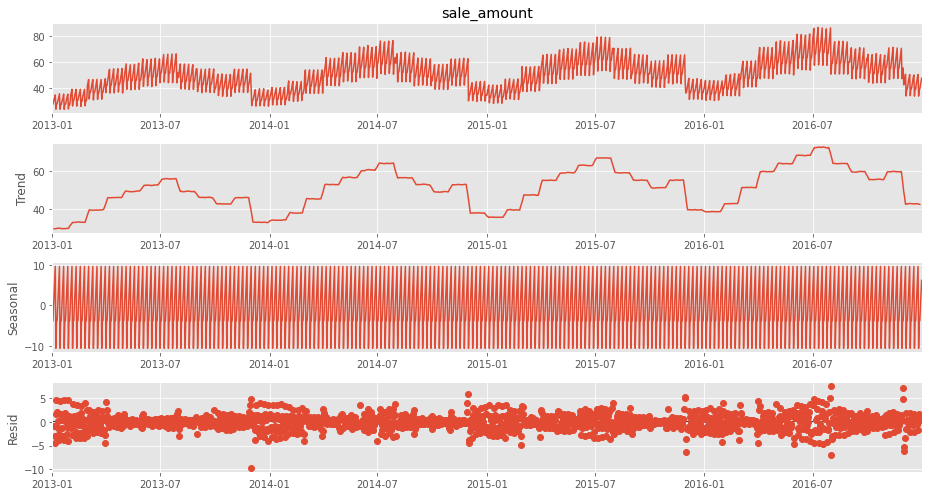

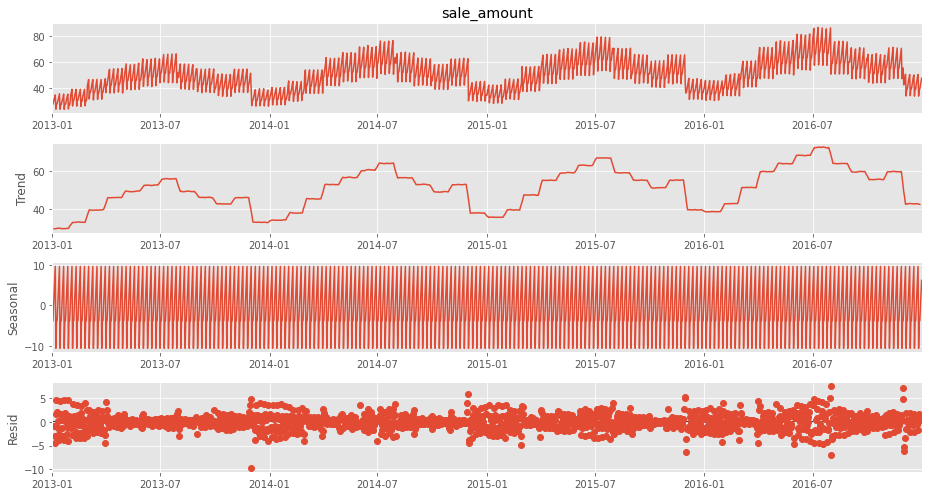

In [15]:
sm.tsa.seasonal_decompose(y).plot()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

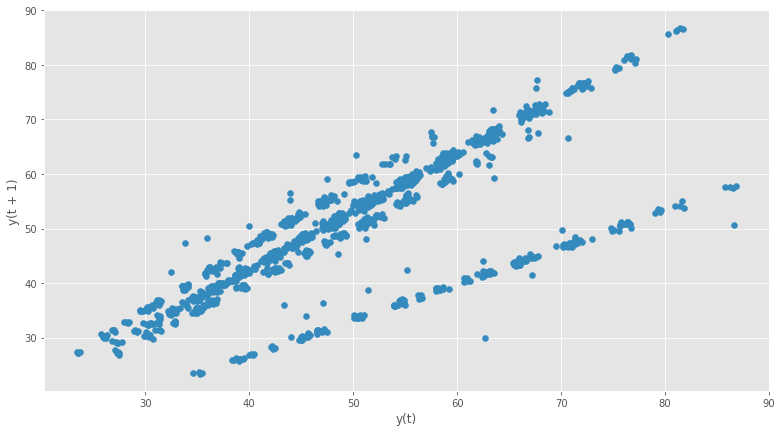

In [16]:
pd.plotting.lag_plot(y)

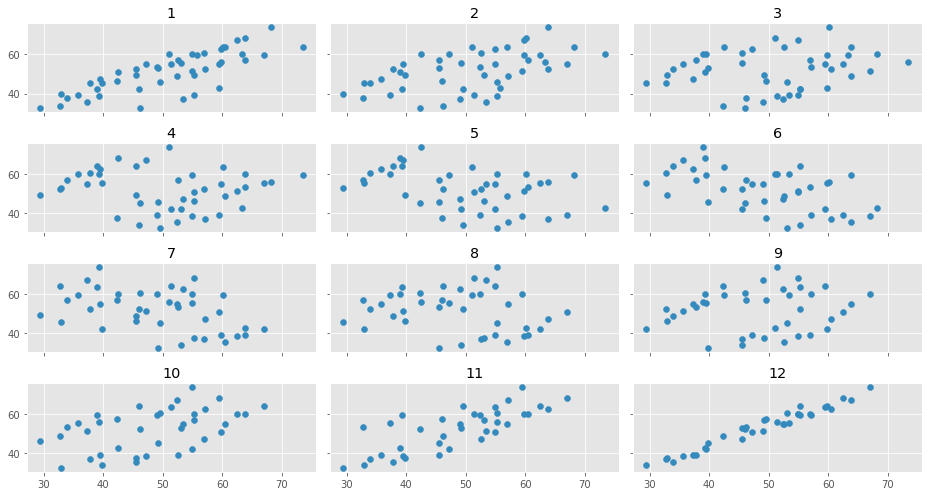

In [17]:
#Look at multiple lag periods for the monthly data
fig, axs = plt.subplots (4, 3, sharex=True, sharey=True)
for ax, lag in zip(axs.ravel(), range(1, 13)):
    pd.plotting.lag_plot(monthly, lag=lag, ax=ax)
    ax.set(title=lag, xlabel='', ylabel='')
fig.tight_layout()

In [18]:
#Correlation test
pd.DataFrame({
    'y':y,
    'y(t+1)': y.shift(-1),
    'y(t+2)': y.shift(-2)}).corr()

,y,y(t+1),y(t+2)
y,1.000000,0.749140,0.666715
y(t+1),0.749140,1.000000,0.748519
y(t+2),0.666715,0.748519,1.000000


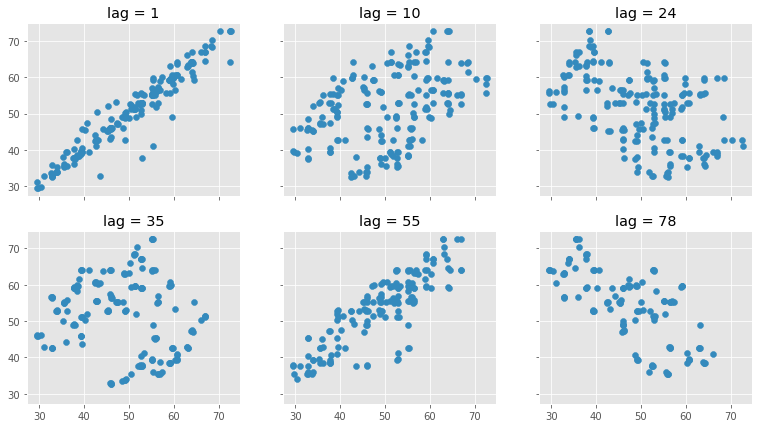

In [19]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for ax, lag in zip(axs.ravel(), [1, 10, 24, 35, 55, 78]):
    pd.plotting.lag_plot(weekly, lag=lag, ax=ax)
    ax.set(title='lag = ' + str(lag), xlabel='', ylabel='')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

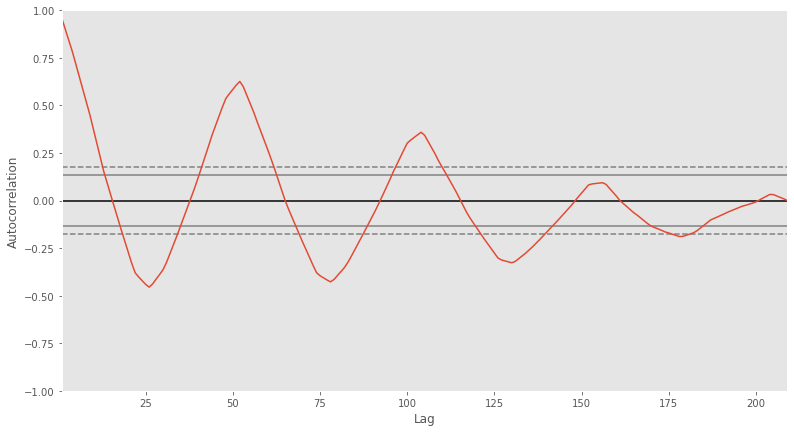

In [20]:
pd.plotting.autocorrelation_plot(weekly)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

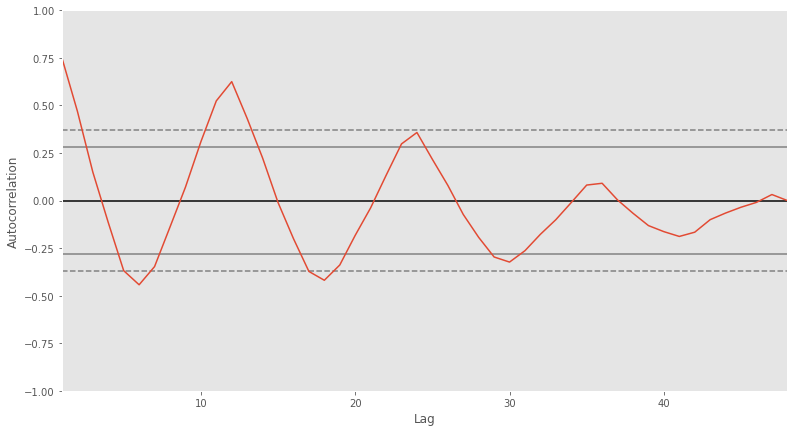

In [21]:
pd.plotting.autocorrelation_plot(y.resample("M").mean())

In [22]:
germany_df = pd.read_csv('https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv')  

In [23]:
germany_df['Date'] = pd.to_datetime(germany_df.Date)

In [24]:
germany_df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [25]:
germany_df.fillna(0)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,0.000,0.000,0.000
1,2006-01-02,1380.52100,0.000,0.000,0.000
2,2006-01-03,1442.53300,0.000,0.000,0.000
3,2006-01-04,1457.21700,0.000,0.000,0.000
4,2006-01-05,1477.13100,0.000,0.000,0.000
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [26]:
train_pct = .8
n = germany_df.shape[0]
test_start_index =round(n * train_pct)

train = germany_df[:test_start_index]
test = germany_df[test_start_index:]

train = train.set_index('Date').resample('D').mean()
test = test.set_index('Date').resample('D').mean()

<AxesSubplot:xlabel='Date'>

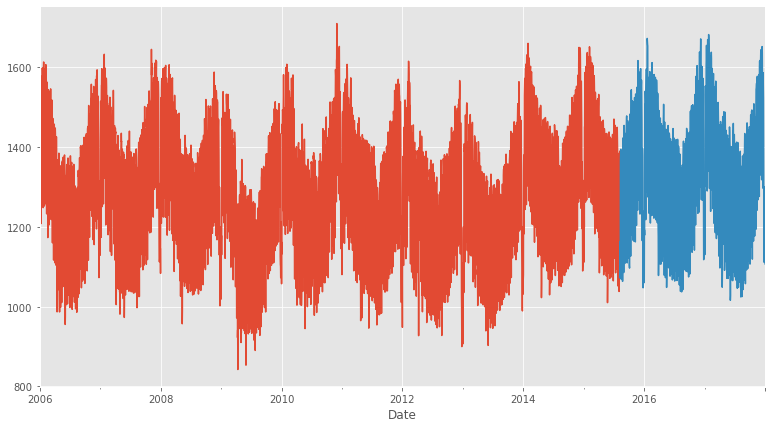

In [27]:
train.Consumption.plot()
test.Consumption.plot()

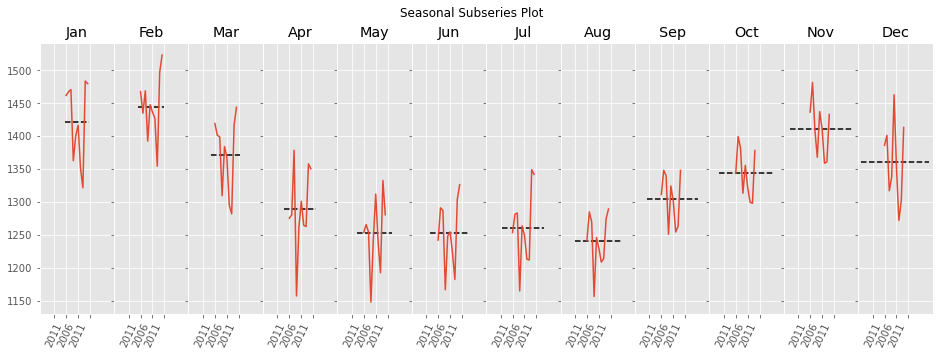

In [28]:
y = train.Consumption

table = y.groupby([y.index.strftime('%Y'), y.index.strftime('%m-%b')]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize=(16, 5))

for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month[3:])
    ax.hlines(subset.mean(), *ax.get_xlim(), color='black', ls='--')
    ax.set(xlabel='')
    ax.tick_params('x', rotation=65)
    
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
# fig.tight_layout()
fig.subplots_adjust(wspace=0)

Text(0, 0.5, '% label')

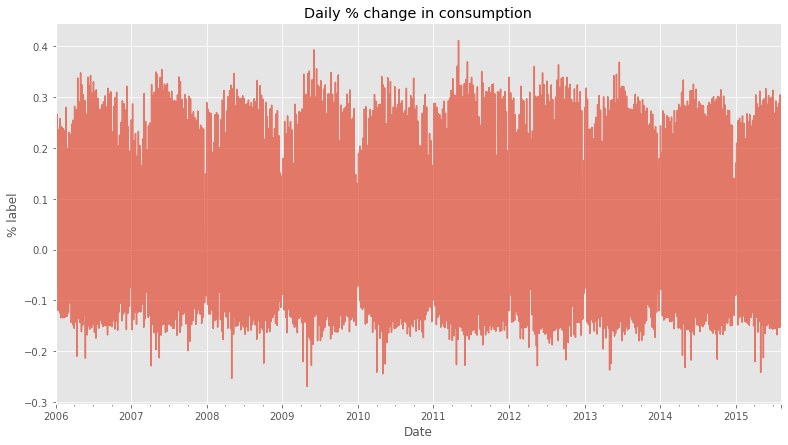

In [29]:
(y.diff()/y.shift()).plot(alpha=.7)
plt.title("Daily % change in consumption")
plt.ylabel("% label")

In [ ]:
sm.tsa.seasonal_decompose(y.resample('M').mean()).plot()
None

In [ ]:
germany_df = germany_df.set_index('Date').fillna(0)

In [ ]:
germany_df.head()

In [ ]:
germany_df['pct_wind'] = germany_df.Wind/germany_df.Consumption
germany_df['pct_solar'] = germany_df.Solar/germany_df.Consumption

In [ ]:
germany_df[['pct_wind', 'pct_solar']].plot()

In [ ]:
germany_df.resample('M').sum()
germany_df['pct_wind'] = germany_df.Wind/germany_df.Consumption
germany_df['pct_solar'] = germany_df.Solar/germany_df.Consumption

In [ ]:
germany_df[['pct_wind', 'pct_solar']].plot.area()